# Biases Investigation on Coco and IAPR-TC-12 Datasets

## 1. Set Up

###1.1 Download Datasets

In [ ]:
# !wget -nc http://images.cocodataset.org/zips/train2017.zip
# !wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# !wget -nc http://www-i6.informatik.rwth-aachen.de/imageclef/resources/iaprtc12.tgz

In order to run the code, first need to upload the data files including coco_images.zip, iaprtc_images.zip, iaprtc_annotation.zip and captions_train2017.json manually. 

In [16]:
# !unzip -n coco_images.zip
!unzip -n iaprtc_images.zip
# !unzip -n iaprtc_annotation.zip
!pip install livelossplot --quiet
!pip -q install transformers

Streaming output truncated to the last 5000 lines.
  inflating: iaprtc_images/12/12560.jpg  
  inflating: __MACOSX/iaprtc_images/12/._12560.jpg  
  inflating: iaprtc_images/12/12548.jpg  
  inflating: __MACOSX/iaprtc_images/12/._12548.jpg  
  inflating: iaprtc_images/12/12010.jpg  
  inflating: __MACOSX/iaprtc_images/12/._12010.jpg  
  inflating: iaprtc_images/12/12004.jpg  
  inflating: __MACOSX/iaprtc_images/12/._12004.jpg  
  inflating: iaprtc_images/12/12762.jpg  
  inflating: __MACOSX/iaprtc_images/12/._12762.jpg  
  inflating: iaprtc_images/12/12992.jpg  
  inflating: __MACOSX/iaprtc_images/12/._12992.jpg  
  inflating: iaprtc_images/12/12986.jpg  
  inflating: __MACOSX/iaprtc_images/12/._12986.jpg  
  inflating: iaprtc_images/12/12979.jpg  
  inflating: __MACOSX/iaprtc_images/12/._12979.jpg  
  inflating: iaprtc_images/12/12951.jpg  
  inflating: __MACOSX/iaprtc_images/12/._12951.jpg  
  inflating: iaprtc_images/12/12602.jpg  
  inflating: __MACOSX/iaprtc_images/12/._12602.jpg  

### 1.2 Import Necessary Libaries

In [10]:
import os
import json
import glob
import random
!pip install transformers --quiet
import torch, logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)
from transformers import BertTokenizer
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn import tree, metrics, svm
import numpy as np
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

## 2 Text Classification

### 2.1 Build Text Dataset 

In [ ]:
data_sample = open("iaprtc_annotation/00/112.eng").read().split('\n')

In [ ]:
data_sample

['<DOC>',
 '<DOCNO>annotations/00/112.eng</DOCNO>',
 '<TITLE>Excursion with the godchildren</TITLE>',
 "<DESCRIPTION>About 20 kids in traditional clothing and hats waiting on stairs; a house and a green wall with gate in the background; a sign saying that plants can't be picked up on the right;</DESCRIPTION>",
 '<NOTES></NOTES>',
 '<LOCATION>Quilotoa, Ecuador</LOCATION>',
 '<DATE>April 2002</DATE>',
 '<IMAGE>images/00/112.jpg</IMAGE>',
 '<THUMBNAIL>thumbnails/00/112.jpg</THUMBNAIL>',
 '</DOC>']

In [ ]:
iaprtc_text_data = []
dir = "iaprtc_annotation/**/*.eng"

for f in glob.iglob(dir):
  # print(f)
  try:
    # print(f)
    annotation = open(f).read().split('\n')[3]
    annotation = annotation[13:-15]
    iaprtc_text_data.append([annotation, 1])
  except:
    continue
iaprtc_text_data = iaprtc_text_data[:15000]
iaprtc_text_data[:10]

[['a grey pavement with very colourful houses on the left and dark green palms and trees on the right;',
  1],
 ['four men and a woman are standing with drums and sticks in the foreground; a person is taking photos in the background;',
  1],
 ['a group of people is riding on brown and white horses on a flat meadow with light brown grass in the foreground; dark green and brown mountains and grey, rocky, snow-covered summits behind it; a white and blue sky in the background;',
  1],
 ['eight people are standing and sitting in front of a grey fountain on a square with a grey paving and high palms in the foreground; a white, two-storey building with brown columns, white arches and a reddish-brown roof behind it; a white church with two towers and white clouds in a blue sky in the background;',
  1],
 ['a black railing in the foreground; a red floor and a white wall with a black door in the background;',
  1],
 ['a group of people is standing on a grey square with green lawns, four high pal

In [ ]:
### Use title
iaprtc_text_data = []
# dir = "iaprtc12/annotations_complete_eng/**/*.eng"
dir = "iaprtc_annotation/**/*.eng"

for f in glob.iglob(dir):
  # print(f)
  try:
    # print(f)
    annotation = open(f).read().split('\n')[2]
    annotation = annotation[7:-8]
    iaprtc_text_data.append([annotation, 1])
  except:
    continue
iaprtc_text_data = iaprtc_text_data[:15000]
iaprtc_text_data[:10]

[['The Nightlife District Bellavista', 1],
 ['Samba and drumming lessons', 1],
 ['Ride to the cliffs near Villa Cerro Castillo', 1],
 ['The Group on the Plaza San Francisco', 1],
 ['The Language School in Cusco', 1],
 ['The group on the Plaza de Armas in Lima', 1],
 ['Group photo at the Pisco Distillery El Catador', 1],
 ['Christa, Birgit and Dirk in the (very German) city of Blumenau', 1],
 ['The Main Square of Tarabuco', 1],
 ['Spider Monkey Dance at the AmaZOOnico', 1]]

In [ ]:
text_data = json.load(open('captions_train2017.json'))
text_data['annotations'][0:3]

[{'caption': 'A bicycle replica with a clock as the front wheel.',
  'id': 37,
  'image_id': 203564},
 {'caption': 'A room with blue walls and a white sink and door.',
  'id': 49,
  'image_id': 322141},
 {'caption': 'A car that seems to be parked illegally behind a legally parked car',
  'id': 89,
  'image_id': 16977}]

In [ ]:
# text_data = json.load(open('annotations/captions_train2017.json'))
text_data = json.load(open('captions_train2017.json'))

coco_text_data = []
text = text_data['annotations']
for i in range(15000):
  coco_text_data.append([text[i]['caption'][:-1], 0])
coco_text_data[:10]

[['A bicycle replica with a clock as the front wheel', 0],
 ['A room with blue walls and a white sink and door', 0],
 ['A car that seems to be parked illegally behind a legally parked ca', 0],
 ['A large passenger airplane flying through the air', 0],
 ['There is a GOL plane taking off in a partly cloudy sky', 0],
 ['Blue and white color scheme in a small bathroom', 0],
 ['This is a blue and white bathroom with a wall sink and a lifesaver on the wall',
  0],
 ['A blue boat themed bathroom with a life preserver on the wal', 0],
 ['The bike has a clock as a tire', 0],
 ['two cars parked on the sidewalk on the stree', 0]]

In [ ]:
text_dataset = coco_text_data + iaprtc_text_data
random.shuffle(text_dataset)
text_dataset[:10]

[['eight tourists are posing on a brown hill at a steep coast at the sea; there is a natural rock bridge in the background',
  1],
 ['There are several bikes parked outside of a buildin', 0],
 ['A person on a motor bike on a road', 0],
 ['a dark-skinned girl with a brown hat and a white cape in the foreground; a lake with a steep brown shore and a dense fog in the background;',
  1],
 ['white llamas in a mountain landscape with green bushes in the foreground and snow covered peaks in the background',
  1],
 ['a bay with blue and brown water; green trees and bushes and a grey jetty in the foreground; a steep, dark green mountain, houses and white clouds in the blue sky in the background;',
  1],
 ['three tourists are sitting (and one is standing) in the middle of a flat desert landscape with dry tussocks, several lagoons and brown, low mountains in the background',
  1],
 ['Two men, one reading, one on his phone, sit on park benches near a flower bed',
  0],
 ['the grey high-rise buildi

In [ ]:
# Data Combination
df_text = DataFrame (text_dataset,columns=['caption','label'])
df_text.head()

,caption,label
0,eight tourists are posing on a brown hill at a...,1
1,There are several bikes parked outside of a bu...,0
2,A person on a motor bike on a road,0
3,a dark-skinned girl with a brown hat and a whi...,1
4,white llamas in a mountain landscape with gree...,1


In [ ]:
input_x = df_text['caption']
input_x[:5]

0    eight tourists are posing on a brown hill at a...
1    There are several bikes parked outside of a bu...
2                   A person on a motor bike on a road
3    a dark-skinned girl with a brown hat and a whi...
4    white llamas in a mountain landscape with gree...
Name: caption, dtype: object

### 2.2 Data Preprocessing

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [ ]:
input = tokenizer(df_text['caption'].values.tolist())

In [ ]:
tokenized_text = input['input_ids']

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(tokenized_text, df_text['label'], test_size=0.33, random_state=42)

In [ ]:
X_train = np.array(X_train)
y_train = y_train.to_numpy()
X_test = np.array(X_test)
y_test = y_test.to_numpy()

l_train = np.array([len(X_train[i]) for i in range(len(X_train))])
l_test = np.array([len(X_test[i]) for i in range(len(X_test))])
width = max(l_train.max(),l_test.max())

def padding(data):
  b=[]
  for i in range(len(data)):
    if len(data[i]) != width:
      x = np.pad(data[i], (0,width-len(data[i])), 'constant',constant_values = 0)
    else:
      x = data[i]
    b.append(x)
  b = np.array(b)
  return b

X_train = padding(X_train)
X_test = padding(X_test)


### 2.3 SVM Classifier

Use Iaprtc Description as Annotation Text

In [ ]:
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
import numpy as np
SVM = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto')
SVM.fit(X_train,y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

SVM Accuracy Score ->  53.848484848484844


Use Iaprtc Title as Annotation Text

In [ ]:
SVM = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto')
SVM.fit(X_train,y_train)
# predict the labels on validation dataset
y_pred = SVM.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n",metrics.confusion_matrix(y_test, y_pred))

Accuracy: 0.673939393939394
Confusion Matrix: 
 [[4940    0]
 [3228 1732]]


### 2.4 Decision Tree Classifier

Use Iaprtc Description as Annotation Text

In [ ]:
# clf = tree.DecisionTreeClassifier()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(list(X_train), y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n",metrics.confusion_matrix(y_test, y_pred))

Accuracy: 0.9248484848484848
Confusion Matrix: 
 [[4532  387]
 [ 357 4624]]


Use Iaprtc Title as Annotation Text

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(list(X_train), y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n",metrics.confusion_matrix(y_test, y_pred))

Accuracy: 0.9285858585858586
Confusion Matrix: 
 [[4561  379]
 [ 328 4632]]


### 2.5 Neural Network Model

In [ ]:
!pip install transformers --quiet
import torch, logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)
from transformers import BertTokenizer
inputs_X = []
outputs_Y = []

for i in range(len(text_dataset)):
  inputs_X.append(text_dataset[0])
  outputs_Y.append(text_dataset[1])

train_inputs_X = inputs_X[:20100]  # The first 300.
train_outputs_Y = np.array(outputs_Y[:20100]) # The first 300 (also turn into np.array).

val_inputs_X = inputs_X[20100:] # The rest.
val_outputs_Y = np.array(outputs_Y[20100:]) # The rest (also turn into np.array)

# Adding pytorch inheritance to use pytorch's Dataloaders.
# The Dataset class must implement __get__ and __len__
class AdvancedTextDataset(torch.utils.data.Dataset):
    def __init__(self, input_texts: list, 
                 output_labels: list):
        self.input_texts = input_texts
        self.output_labels = output_labels

        # Use the sub-word tokenizers from the library here.
        self.tokenizer = \
            BertTokenizer.from_pretrained('bert-base-multilingual-cased')

        self.vocab = self.tokenizer.get_vocab()
        self.reverse_vocab = \
            {index: token for (token, index) in self.vocab.items()}

    def __getitem__(self, i: int) -> tuple:
        text = self.input_texts[i]
        # Tokenize the text.
        tokenized_text = self.tokenize(text)
        label = self.output_labels[i]
        return tokenized_text, label

    def __len__(self) -> int:
        return len(self.output_labels)

    def tokenize(self, text: str):
        return self.tokenizer.encode(text)

    def untokenize(self, tokens: list):
        # Use the sub-word tokenizers from the library here.
        return self.tokenizer.convert_tokens_to_ids(tokens)

    def token2index(self, token: str) -> int:
        # Use the sub-word tokenizers from the library here.
        return self.vocab[token]

    def index2token(self, index: int) -> str:
        # Use the sub-word tokenizers from the library here.
        return self.reverse_vocab[index]

    def vocab_size(self) -> int:
        # Use the sub-word tokenizers from the library here.
        return len(self.tokenizer.get_vocab())

# Create instances for the train and validation dataset.
adv_train_data = AdvancedTextDataset(train_inputs_X, train_outputs_Y)
adv_val_data = AdvancedTextDataset(val_inputs_X, val_outputs_Y)

# Print the length of training and validation.
print(len(adv_train_data))
print(len(adv_val_data))

# Test the tokenization and untokenization.
x,y = adv_val_data[90]

20100
9900


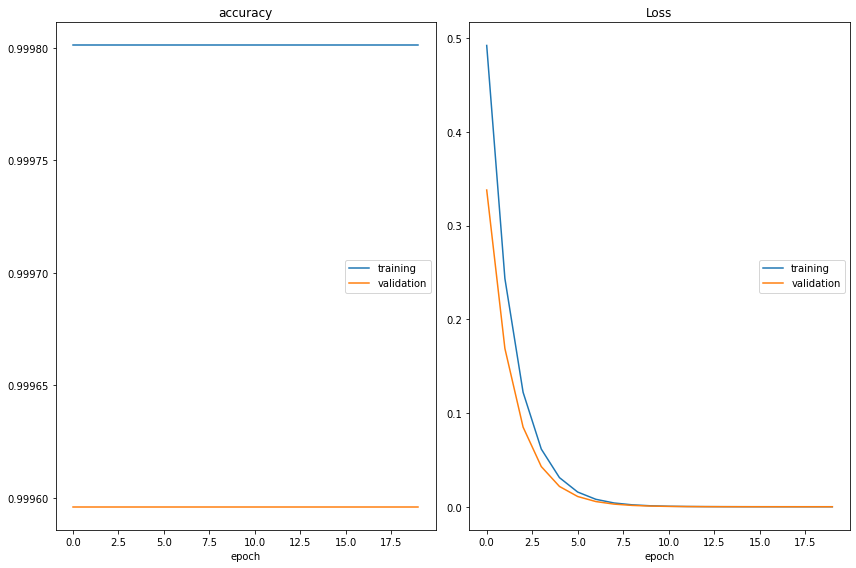

accuracy
	training         	 (min:    1.000, max:    1.000, cur:    1.000)
	validation       	 (min:    1.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.000, max:    0.492, cur:    0.000)
	validation       	 (min:    0.000, max:    0.338, cur:    0.000)


<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install livelossplot --quiet

import random
import torch.optim as optim
from livelossplot import PlotLosses

n_epochs = 20
batch_size = 8
learningRate = 1e-4
encodingSize = adv_train_data.vocab_size()

# Encode BOW - encoding Size should change!
def encode_text(tokens):
    token_ids = np.array(tokens)
    bow_vector = np.zeros((1, encodingSize)) # Start with all zeros.
    bow_vector[0, token_ids] = 1 # Put ones in token_id locations.
    return bow_vector

# Pytorch data loaders already sample random inputs.
# We just need to put them in a batch and encode.
def create_batch(inputs):
    batch_size = len(inputs)
    input_x = np.zeros((batch_size, encodingSize))
    output_y = np.zeros(batch_size)
    for (i, (tokens, label)) in enumerate(inputs):
        input_x[i, :] = encode_text(tokens)
        label = int(label[1])
        # print(label)
        output_y[i] = 1 if (label > 0) else 0
    return input_x, output_y

# Create the data loaders.
train_loader = torch.utils.data.DataLoader(adv_train_data, 
                                           batch_size = batch_size, 
                                           collate_fn = create_batch, shuffle = True)
val_loader = torch.utils.data.DataLoader(adv_val_data, 
                                         batch_size = batch_size, 
                                         collate_fn = create_batch, shuffle = False)

# I like to use BCEWithLogits so that the classifier doesn't need Sigmoid.
cost_function = nn.BCEWithLogitsLoss()
# Classifier now doesn't need sigmoid because it is incoporated in the loss.
# Also why don't add another linear layer and make it a 2-layer nn?
model = nn.Linear(encodingSize, 1)
# Same optimizer as before. 
optimizer = optim.Adam(model.parameters(), lr = learningRate)

# GPU.
model = model.cuda()
cost_function = cost_function.cuda()

best_accuracy = 0 
liveloss = PlotLosses()
for epoch in range(0, n_epochs):
    correct = 0
    cumulative_loss = 0
    logs = {}
    model.train()
    for (batch_id, (xb, yb)) in enumerate(train_loader):
        model.zero_grad()

        # Move data to pytorch tensors.
        xb = torch.tensor(xb, dtype=torch.float32, requires_grad = True).cuda()
        yb = torch.tensor(yb, dtype=torch.float32).cuda()

        # Compute predictions.
        predicted = model(xb)

        # Compute loss.
        loss = cost_function(predicted, yb[:, None])
        cumulative_loss += loss.data
        predicted_ = torch.sigmoid(predicted.detach())
        correct += ((predicted_ > 0.5) == yb[:, None]).sum().item()

        # Compute gradients (autograd).
        loss.backward()

        # Run one basic training step of SGD.
        optimizer.step()

        logs['loss'] = cumulative_loss / (1 + batch_id)
        logs['accuracy'] = correct / ((1 + batch_id) * batch_size)
    
    correct = 0
    cumulative_loss = 0
    model.eval()
    with torch.no_grad():
        for (batch_id, (xb, yb)) in enumerate(val_loader):
            # Move data to pytorch tensors.
            xb = torch.tensor(xb, dtype=torch.float32, requires_grad = True).cuda()
            yb = torch.tensor(yb, dtype=torch.float32).cuda()
        
            # Compute predictions.
            predicted = model(xb)

            # Compute loss.
            loss = cost_function(predicted, yb[:, None])
            cumulative_loss += loss.data
            predicted_ = torch.sigmoid(predicted.detach())
            correct += ((predicted_ > 0.5) == yb[:, None]).sum().item()

            logs['val_loss'] = cumulative_loss / (1 + batch_id)
            logs['val_accuracy'] = correct / ((1 + batch_id) * batch_size)

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth')

    liveloss.update(logs)
    liveloss.send()

# Load the model parameters for the one that achieved the best val accuracy.
model.load_state_dict(torch.load('best_model_so_far.pth'))  

Use IAPR Titile

In [ ]:
!pip install transformers --quiet
import torch, logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)
from transformers import BertTokenizer
inputs_X = []
outputs_Y = []

for i in range(len(text_dataset)):
  inputs_X.append(text_dataset[0])
  outputs_Y.append(text_dataset[1])

train_inputs_X = inputs_X[:20100]  # The first 300.
train_outputs_Y = np.array(outputs_Y[:20100]) # The first 300 (also turn into np.array).

val_inputs_X = inputs_X[20100:] # The rest.
val_outputs_Y = np.array(outputs_Y[20100:]) # The rest (also turn into np.array)

# Adding pytorch inheritance to use pytorch's Dataloaders.
# The Dataset class must implement __get__ and __len__
class AdvancedTextDataset(torch.utils.data.Dataset):
    def __init__(self, input_texts: list, 
                 output_labels: list):
        self.input_texts = input_texts
        self.output_labels = output_labels

        # Use the sub-word tokenizers from the library here.
        self.tokenizer = \
            BertTokenizer.from_pretrained('bert-base-multilingual-cased')

        self.vocab = self.tokenizer.get_vocab()
        self.reverse_vocab = \
            {index: token for (token, index) in self.vocab.items()}

    def __getitem__(self, i: int) -> tuple:
        text = self.input_texts[i]
        # Tokenize the text.
        tokenized_text = self.tokenize(text)
        label = self.output_labels[i]
        return tokenized_text, label

    def __len__(self) -> int:
        return len(self.output_labels)

    def tokenize(self, text: str):
        return self.tokenizer.encode(text)

    def untokenize(self, tokens: list):
        # Use the sub-word tokenizers from the library here.
        return self.tokenizer.convert_tokens_to_ids(tokens)

    def token2index(self, token: str) -> int:
        # Use the sub-word tokenizers from the library here.
        return self.vocab[token]

    def index2token(self, index: int) -> str:
        # Use the sub-word tokenizers from the library here.
        return self.reverse_vocab[index]

    def vocab_size(self) -> int:
        # Use the sub-word tokenizers from the library here.
        return len(self.tokenizer.get_vocab())

# Create instances for the train and validation dataset.
adv_train_data = AdvancedTextDataset(train_inputs_X, train_outputs_Y)
adv_val_data = AdvancedTextDataset(val_inputs_X, val_outputs_Y)

# Print the length of training and validation.
print(len(adv_train_data))
print(len(adv_val_data))

# Test the tokenization and untokenization.
x,y = adv_val_data[90]

20100
9900


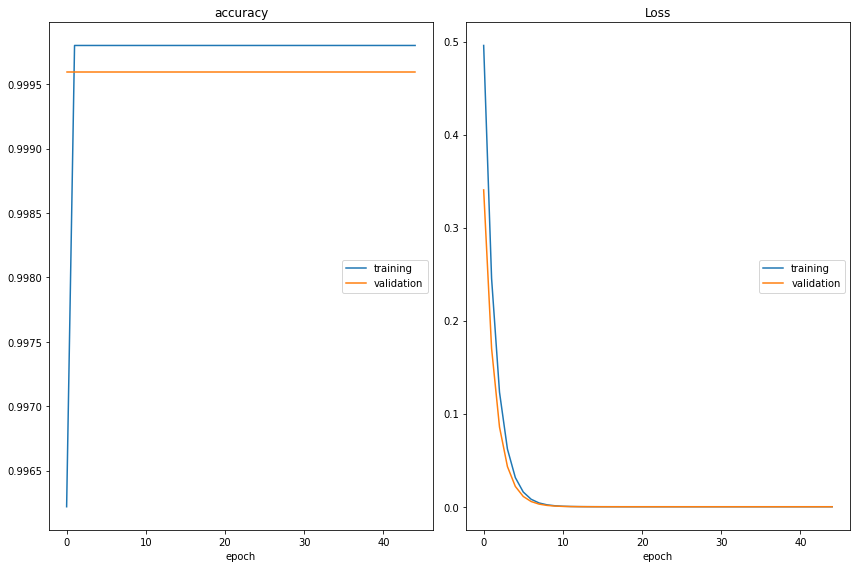

accuracy
	training         	 (min:    0.996, max:    1.000, cur:    1.000)
	validation       	 (min:    1.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.000, max:    0.496, cur:    0.000)
	validation       	 (min:    0.000, max:    0.341, cur:    0.000)


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install livelossplot --quiet

import random
import torch.optim as optim
from livelossplot import PlotLosses

n_epochs = 50
batch_size = 8
learningRate = 1e-4
encodingSize = adv_train_data.vocab_size()


def encode_text(tokens):
    token_ids = np.array(tokens)
    bow_vector = np.zeros((1, encodingSize)) # Start with all zeros.
    bow_vector[0, token_ids] = 1 # Put ones in token_id locations.
    return bow_vector


def create_batch(inputs):
    batch_size = len(inputs)
    input_x = np.zeros((batch_size, encodingSize))
    output_y = np.zeros(batch_size)
    for (i, (tokens, label)) in enumerate(inputs):
        input_x[i, :] = encode_text(tokens)
        label = int(label[1])
        # print(label)
        output_y[i] = 1 if (label > 0) else 0
    return input_x, output_y

train_loader = torch.utils.data.DataLoader(adv_train_data, 
                                           batch_size = batch_size, 
                                           collate_fn = create_batch, shuffle = True)
val_loader = torch.utils.data.DataLoader(adv_val_data, 
                                         batch_size = batch_size, 
                                         collate_fn = create_batch, shuffle = False)

# I like to use BCEWithLogits so that the classifier doesn't need Sigmoid.
cost_function = nn.BCEWithLogitsLoss()
# Classifier now doesn't need sigmoid because it is incoporated in the loss.
# Also why don't add another linear layer and make it a 2-layer nn?
model = nn.Linear(encodingSize, 1)
# Same optimizer as before. 
optimizer = optim.Adam(model.parameters(), lr = learningRate)

# GPU.
model = model.cuda()
cost_function = cost_function.cuda()

best_accuracy = 0 
liveloss = PlotLosses()
for epoch in range(0, n_epochs):
    correct = 0
    cumulative_loss = 0
    logs = {}
    model.train()
    for (batch_id, (xb, yb)) in enumerate(train_loader):
        model.zero_grad()

        # Move data to pytorch tensors.
        xb = torch.tensor(xb, dtype=torch.float32, requires_grad = True).cuda()
        yb = torch.tensor(yb, dtype=torch.float32).cuda()

        # Compute predictions.
        predicted = model(xb)

        # Compute loss.
        loss = cost_function(predicted, yb[:, None])
        cumulative_loss += loss.data
        predicted_ = torch.sigmoid(predicted.detach())
        correct += ((predicted_ > 0.5) == yb[:, None]).sum().item()

        # Compute gradients (autograd).
        loss.backward()

        # Run one basic training step of SGD.
        optimizer.step()

        logs['loss'] = cumulative_loss / (1 + batch_id)
        logs['accuracy'] = correct / ((1 + batch_id) * batch_size)
    
    correct = 0
    cumulative_loss = 0
    model.eval()
    with torch.no_grad():
        for (batch_id, (xb, yb)) in enumerate(val_loader):
            # Move data to pytorch tensors.
            xb = torch.tensor(xb, dtype=torch.float32, requires_grad = True).cuda()
            yb = torch.tensor(yb, dtype=torch.float32).cuda()
        
            # Compute predictions.
            predicted = model(xb)

            # Compute loss.
            loss = cost_function(predicted, yb[:, None])
            cumulative_loss += loss.data
            predicted_ = torch.sigmoid(predicted.detach())
            correct += ((predicted_ > 0.5) == yb[:, None]).sum().item()

            logs['val_loss'] = cumulative_loss / (1 + batch_id)
            logs['val_accuracy'] = correct / ((1 + batch_id) * batch_size)

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth')

    liveloss.update(logs)
    liveloss.send()

# Load the model parameters for the one that achieved the best val accuracy.
model.load_state_dict(torch.load('best_model_so_far.pth'))  

## 3 Image Classification

### 3.1 Image Dataset

In [2]:
# from PIL import Image
# img = Image.open("iaprtc12/images/00/112.jpg").convert('RGB')

In [3]:
iaprtc_image_data = []
dir = "iaprtc_images/**/*.jpg"
count = 0
for f in glob.iglob(dir):
  if count < 1000:
    count+=1
  # print(f)
    try:
      # print(f)
      img = Image.open(f).convert('RGB')
      iaprtc_image_data.append([img, 1])
    except:
      continue
  else:
    break

print(len(iaprtc_image_data))

1000


In [4]:
coco_image_data = []
dir = "coco_images/*.jpg"
count = 0
for f in glob.iglob(dir):
  if count < 1000:
    count+=1
    # print(f)
    try:
      # print(f)
      img = Image.open(f).convert('RGB')
      coco_image_data.append([img, 0])
    except:
      continue
  else:
    break
# iaprtc_image_data = iaprtc_image_data[:15000]
print(len(coco_image_data))
# coco_image_data = coco_image_data[:100]

1000


In [5]:
image_dataset = coco_image_data + iaprtc_image_data
random.shuffle(image_dataset)
image_dataset[:10]

[[<PIL.Image.Image image mode=RGB size=480x360 at 0x7F9C384B81D0>, 1],
 [<PIL.Image.Image image mode=RGB size=320x480 at 0x7F9C38531240>, 1],
 [<PIL.Image.Image image mode=RGB size=640x384 at 0x7F9C382C1BE0>, 0],
 [<PIL.Image.Image image mode=RGB size=480x640 at 0x7F9C382F5588>, 0],
 [<PIL.Image.Image image mode=RGB size=480x360 at 0x7F9C384D9FD0>, 1],
 [<PIL.Image.Image image mode=RGB size=360x480 at 0x7F9C3842C748>, 1],
 [<PIL.Image.Image image mode=RGB size=640x480 at 0x7F9C3842E1D0>, 0],
 [<PIL.Image.Image image mode=RGB size=424x640 at 0x7F9C38303D68>, 0],
 [<PIL.Image.Image image mode=RGB size=480x360 at 0x7F9C384930F0>, 1],
 [<PIL.Image.Image image mode=RGB size=480x640 at 0x7F9C38319F98>, 0]]

In [6]:
val_set = image_dataset[1400:]

In [7]:
import torchvision.transforms as transforms
image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])



In [8]:

dataset = []
for i in range(len(image_dataset)):
  trans = image_transform(image_dataset[i][0])
  dataset.append([trans, image_dataset[i][1]])




### 3.2 ResNet Model

In [10]:

# # This solution uses more regularization and more parameters.


class SceneClassifier(torch.nn.Module):
    def __init__(self):
        super(SceneClassifier, self).__init__()
        self.pretrained = torchvision.models.resnext101_32x8d(pretrained = True)
        self.pretrained.fc = torch.nn.Identity()

        self.linear = torch.nn.Linear(2048, 1)


    def forward(self, x):
        
        x = self.pretrained(x)
        x = self.linear(x)
        return x


model = SceneClassifier()
model = model.cuda()

from livelossplot import PlotLosses

def train_model(batch_size, 
                n_epochs, 
                learningRate, 
                model, 
                cost_function, 
                optimizer,
                scheduler,
                train_loader,
                val_loader):

    # GPU.
    model = model.cuda()
    cost_function = cost_function.cuda()

    best_accuracy = 0 
    liveloss = PlotLosses()
    current_step = 0
    for epoch in range(0, n_epochs):
        # correct = 0
        cumulative_loss = 0
        cumulative_accuracy = 0
        num_samples = 0
        logs = {}
        model.train()
        for (batch_id, (xb,yb)) in enumerate(train_loader):
            model.zero_grad()

            # Move data to GPU.
            xb = xb.cuda()
            # yb = yb
            predicted = model(xb)
            yb = torch.reshape(yb,(5,1))
            yb = yb.type_as(predicted)
            yb = yb.cuda()
            # Compute loss.
            loss = cost_function(predicted, yb)
            # print("come through")
            cumulative_loss += loss.data.sum().item()
            for i in range(5):
              if yb[i] == 1 and predicted[i] > 0.5:
                cumulative_accuracy +=1
              elif yb[i] == 0 and predicted[i] < 0.5:
                cumulative_accuracy +=1
              else:
                cumulative_accuracy +=0
            num_samples += xb.size(0)

            # Compute gradients (autograd).
            loss.mean().backward()

            # Run one basic training step of SGD.
            optimizer.step()

            if batch_id % 100 == 0:
                print(epoch, batch_id, cumulative_accuracy / num_samples)
                logs['loss'] = cumulative_loss / num_samples
                logs['accuracy'] = cumulative_accuracy / num_samples
                liveloss.update(logs)
                liveloss.send()
                current_step += 1
        
        cumulative_loss = 0
        cumulative_accuracy = 0
        num_samples = 0
        model.eval()
        # print("val loader")
        with torch.no_grad():
            for (batch_id, (xb,yb)) in enumerate(val_loader):
                # Move data to GPU.
                xb = xb.cuda()
                # yb = yb.cuda()
                # Compute predictions.
                predicted = model(xb)
                yb = torch.reshape(yb,(5,1))
                yb = yb.type_as(predicted)
                yb = yb.cuda()

                loss = cost_function(predicted, yb)
                # print("come through")
                cumulative_loss += loss.data.sum().item()
                for i in range(5):
                  if yb[i] == 1 and predicted[i] > 0.5:
                    cumulative_accuracy +=1
                  elif yb[i] == 0 and predicted[i] < 0.5:
                    cumulative_accuracy +=1
                  else:
                    cumulative_accuracy +=0
                num_samples += xb.size(0)


                if (1 + batch_id) % 100 == 0:
                  logs['val_loss'] = cumulative_loss / num_samples
                  logs['val_accuracy'] = cumulative_accuracy / num_samples    
                  liveloss.update(logs, current_step)
                  liveloss.send()
        # print(logs['val_accuracy'])



        if scheduler != -1:
            scheduler.step()
        # print(logs['val_accuracy'])
        if logs['val_accuracy'] > best_accuracy:
          best_accuracy = logs['val_accuracy']
          torch.save(model.state_dict(), 'best_model_so_far.pth') 

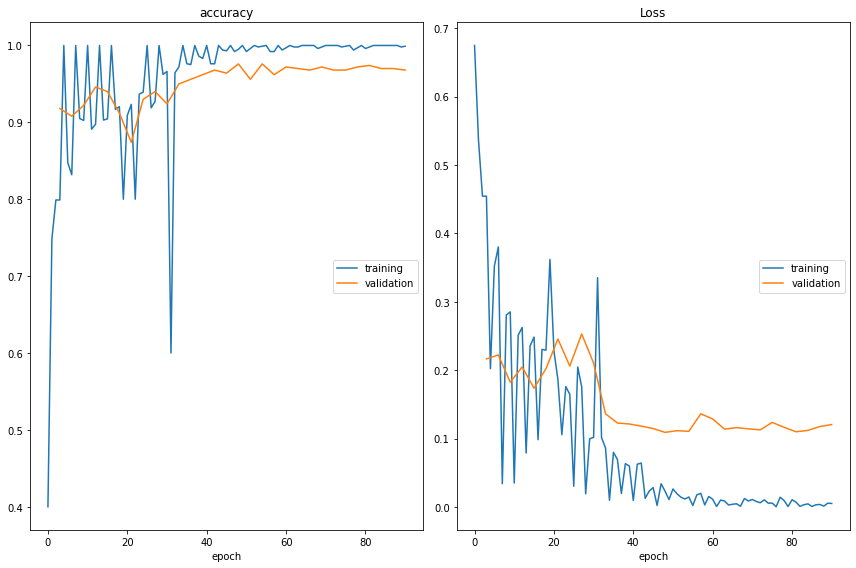

accuracy
	training         	 (min:    0.400, max:    1.000, cur:    0.999)
	validation       	 (min:    0.874, max:    0.976, cur:    0.968)
Loss
	training         	 (min:    0.000, max:    0.675, cur:    0.005)
	validation       	 (min:    0.109, max:    0.253, cur:    0.120)


In [ ]:
import torch.nn as nn
batch_size = 5
n_epochs = 30
learningRate = 1e-3

cost_function = nn.BCEWithLogitsLoss(reduction = 'none')

 
optimizer = torch.optim.Adam([{'params': model.pretrained.parameters(), 'lr': 1e-4},
                              {'params': model.linear.parameters()}], 
                              lr = learningRate)

trainset = dataset[:1400]
valset = dataset[1400:]
train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 4)
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)
train_model(batch_size, n_epochs, learningRate, 
            model, cost_function, optimizer, scheduler, 
            train_loader, val_loader)


In [11]:
def show_image_group(dataset, image_ids, n_images):
    image_ids = image_ids[:n_images]
    Transf = transforms.Compose([transforms.CenterCrop((256, 224)), transforms.ToTensor()])
    imgs = [Transf(dataset.load_image_only(id)) for id in image_ids]
    grid = torchvision.utils.make_grid(imgs, nrow = 10)
    plt.figure(figsize=(20,10)); plt.axis(False)
    plt.imshow(F.to_pil_image(grid));

val_loader = torch.utils.data.DataLoader(dataset[1400:], 
                                         batch_size = 1, 
                                         shuffle = False)


In [24]:
batch_id, (imgs,labels) = next(enumerate(val_loader))
model.eval()
imgs = imgs.cuda()
labels = labels.cuda()
predicted = model(imgs)
print(predicted,labels)

tensor([[-2.8092]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([0], device='cuda:0')


### 3.3 AlexNet Model

In [11]:

# This solution uses more regularization and more parameters.

class SceneClassifier(torch.nn.Module):
    def __init__(self):
        super(SceneClassifier, self).__init__()
        self.pretrained = torchvision.models.alexnet(pretrained = True)
        self.pretrained.fc = torch.nn.Identity()

        self.linear = torch.nn.Linear(1000, 1)


    def forward(self, x):
        
        x = self.pretrained(x)
        x = self.linear(x)
        return x


model = SceneClassifier()
model = model.cuda()

In [12]:
from livelossplot import PlotLosses

def train_model(batch_size, 
                n_epochs, 
                learningRate, 
                model, 
                cost_function, 
                optimizer,
                scheduler,
                train_loader,
                val_loader):

    # GPU.
    model = model.cuda()
    cost_function = cost_function.cuda()

    best_accuracy = 0 
    liveloss = PlotLosses()
    current_step = 0
    for epoch in range(0, n_epochs):
        # correct = 0
        cumulative_loss = 0
        cumulative_accuracy = 0
        num_samples = 0
        logs = {}
        model.train()
        for (batch_id, (xb,yb)) in enumerate(train_loader):
            model.zero_grad()

            # Move data to GPU.
            xb = xb.cuda()
            # yb = yb
            predicted = model(xb)
            # predicted = torch.reshape(predicted, (-1,))
            yb = torch.reshape(yb,(5,1))
            yb = yb.type_as(predicted)
            yb = yb.cuda()
            # Compute loss.
            loss = cost_function(predicted, yb)
            # print("come through")
            cumulative_loss += loss.data.sum().item()
            for i in range(5):
              if yb[i] == 1 and predicted[i] > 0.5:
                cumulative_accuracy +=1
              elif yb[i] == 0 and predicted[i] < 0.5:
                cumulative_accuracy +=1
              else:
                cumulative_accuracy +=0
            num_samples += xb.size(0)

            # Compute gradients (autograd).
            loss.mean().backward()

            # Run one basic training step of SGD.
            optimizer.step()

            if batch_id % 100 == 0:
                print(epoch, batch_id, cumulative_accuracy / num_samples)
                logs['loss'] = cumulative_loss / num_samples
                logs['accuracy'] = cumulative_accuracy / num_samples
                liveloss.update(logs)
                liveloss.send()
                current_step += 1
        
        cumulative_loss = 0
        cumulative_accuracy = 0
        num_samples = 0
        model.eval()
        with torch.no_grad():
            for (batch_id, (xb,yb)) in enumerate(val_loader):
                # Move data to GPU.
                xb = xb.cuda()
                # yb = yb.cuda()
                # Compute predictions.
                predicted = model(xb)
                # predicted = torch.reshape(predicted, (-1,))
                yb = torch.reshape(yb,(5,1))
                yb = yb.type_as(predicted)
                yb = yb.cuda()

                loss = cost_function(predicted, yb)
                # print("come through")
                cumulative_loss += loss.data.sum().item()
                for i in range(5):
                  if yb[i] == 1 and predicted[i] > 0.5:
                    cumulative_accuracy +=1
                  elif yb[i] == 0 and predicted[i] < 0.5:
                    cumulative_accuracy +=1
                  else:
                    cumulative_accuracy +=0
                num_samples += xb.size(0)


                if (1 + batch_id) % 100 == 0:

                  logs['val_loss'] = cumulative_loss / num_samples
                  logs['val_accuracy'] = cumulative_accuracy / num_samples    
                  liveloss.update(logs, current_step)
                  liveloss.send()
        # print(logs['val_accuracy'])



        if scheduler != -1:
            scheduler.step()
        # print(logs['val_accuracy'])
        # if logs['val_accuracy'] > best_accuracy:
        #   best_accuracy = logs['val_accuracy']
          # torch.save(model.state_dict(), 'best_model_so_far.pth') 

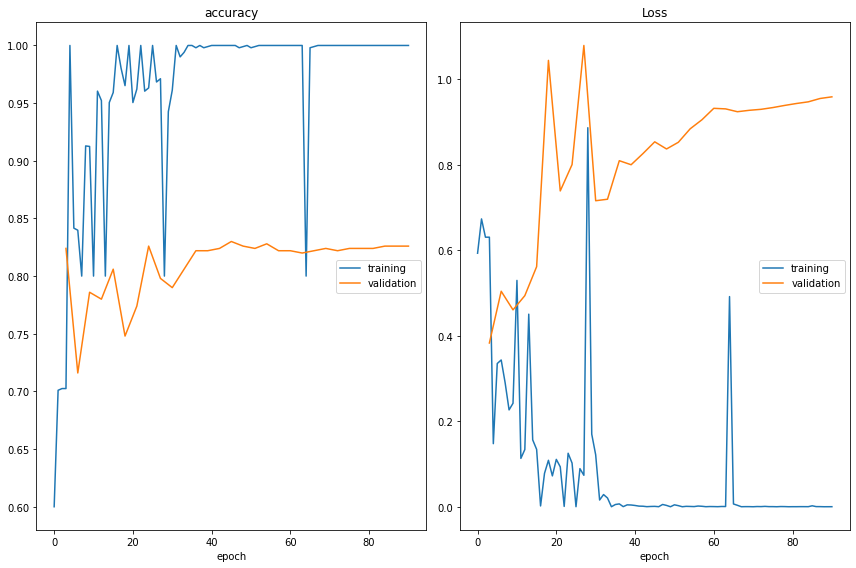

accuracy
	training         	 (min:    0.600, max:    1.000, cur:    1.000)
	validation       	 (min:    0.716, max:    0.830, cur:    0.826)
Loss
	training         	 (min:    0.000, max:    0.887, cur:    0.000)
	validation       	 (min:    0.383, max:    1.079, cur:    0.959)


In [13]:
import torch.nn as nn
batch_size = 5
n_epochs = 30
learningRate = 1e-3

cost_function = nn.BCEWithLogitsLoss(reduction = 'none')

 
optimizer = torch.optim.Adam([{'params': model.pretrained.parameters(), 'lr': 1e-4},
                              {'params': model.linear.parameters()}], 
                              lr = learningRate)

trainset = dataset[:1400]
valset = dataset[1400:]
train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 4)
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)
train_model(batch_size, n_epochs, learningRate, 
            model, cost_function, optimizer, scheduler, 
            train_loader, val_loader)